In [1]:
!pip install yfinance pandas scikit-learn matplotlib tabulate --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

from math import sqrt

In [3]:
ticker_list = pd.read_csv('tickers.csv')["Ticker"].tolist()

In [4]:
tickers = [
    "^GSPC",  # S&P500 Market Index
    "^IRX"  # Short-term Interest Rate Index
] + ticker_list
ticker_hist = yf.download(
                tickers = " ".join(tickers),
                # Download Daily returns for past 2 years
                period = f"{12*2}mo",
                interval = "1d",
                group_by = 'ticker',
                threads = True
            )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  59 of 59 completed


In [5]:
def calculate_daily_returns(closing_prices: pd.Series) -> pd.Series:
    closing_prices = closing_prices.dropna()  # Crude data cleanup
    daily_returns = closing_prices.pct_change().iloc[1:]
    return daily_returns

In [6]:
sp500_returns = calculate_daily_returns(ticker_hist["^GSPC"]["Close"])
ticker_returns = {
    ticker: calculate_daily_returns(ticker_hist[ticker]["Close"])
    for ticker in ticker_list
}
irx_returns = ticker_hist["^IRX"]["Close"] / (365 * 100)
irx_returns = irx_returns[irx_returns.index.isin(sp500_returns.index)]  # Align indices

In [7]:
def calculate_beta(ticker_returns: pd.Series, market_returns: pd.Series, risk_free_rate: pd.Series) -> float:
    # Calculate excess returns
    excess_market_returns = market_returns - risk_free_rate

    # Fit linear regression model
    model = LinearRegression()
    
    # .reshape(-1, 1) does the same thing as [[val] for val in excess_market_returns.values]
    model.fit(excess_market_returns.values.reshape(-1, 1), ticker_returns.values)

    # Beta is the slope of the regression line
    beta = model.coef_[0]
    return beta

In [8]:
# VERY important: Only use data before 2025-01-01. We will test performance starting 2025-01-01
betas_per_stock = {
    ticker: calculate_beta(ticker_returns[ticker].loc[:'2025-01-01'], sp500_returns.loc[:'2025-01-01'], irx_returns.loc[:'2025-01-01'])
    for ticker in ticker_list
}
betas_per_stock_df = pd.DataFrame.from_dict(betas_per_stock, orient='index', columns=['Beta']).sort_values(by='Beta', ascending=False)
betas_per_stock_df.index.name = 'Ticker'

In [9]:
print(pd.concat([betas_per_stock_df.head(10), betas_per_stock_df.tail(10)]).to_markdown(floatfmt=".2f"))

| Ticker   |   Beta |
|:---------|-------:|
| BBAI     |   2.76 |
| SPCE     |   2.35 |
| ACHR     |   2.33 |
| U        |   2.19 |
| RDW      |   1.94 |
| FSLY     |   1.86 |
| SNAP     |   1.84 |
| CCL      |   1.79 |
| GME      |   1.71 |
| BB       |   1.71 |
| ABBV     |   0.23 |
| MRK      |   0.23 |
| MO       |   0.23 |
| XOM      |   0.20 |
| KO       |   0.18 |
| VZ       |   0.14 |
| PG       |   0.13 |
| LMT      |   0.11 |
| JNJ      |   0.06 |
| T        |   0.03 |


In [10]:
# Test different strategies (equally weighted):
# [1] Buy random stocks
# [2] Buy stocks with the highest beta
# [3] Buy stocks with the lowest beta

highest_stock_portfolio_returns = pd.DataFrame({
    ticker: ticker_returns[ticker].loc['2025-01-01':]
    for ticker in betas_per_stock_df.head(10).index
}).mean(axis=1)

lowest_stock_portfolio_returns = pd.DataFrame({
    ticker: ticker_returns[ticker].loc['2025-01-01':]
    for ticker in betas_per_stock_df.tail(10).index
}).mean(axis=1)

np.random.seed(101)  # For reproducibility
random_stock_portfolio_returns = pd.DataFrame({
    ticker: ticker_returns[ticker].loc['2025-01-01':]
    for ticker in np.random.choice(ticker_list, size=10, replace=False)
}).mean(axis=1)

In [11]:
def calculate_total_portfolio_returns(portfolio_returns: pd.Series) -> float:
    return (1 + portfolio_returns).prod() - 1

In [12]:
result = pd.DataFrame({
    "Highest Beta Portfolio": calculate_total_portfolio_returns(highest_stock_portfolio_returns),
    "Lowest Beta Portfolio": calculate_total_portfolio_returns(lowest_stock_portfolio_returns),
    "Random Portfolio": calculate_total_portfolio_returns(random_stock_portfolio_returns)
}, index=["Total Returns"]).T

In [13]:
variances = pd.DataFrame({
    "Highest Beta Portfolio": highest_stock_portfolio_returns.std() * sqrt(len(highest_stock_portfolio_returns)),
    "Lowest Beta Portfolio": lowest_stock_portfolio_returns.std() * sqrt(len(lowest_stock_portfolio_returns)),
    "Random Portfolio": random_stock_portfolio_returns.std() * sqrt(len(random_stock_portfolio_returns))
}, index=["risk"]).T

In [14]:
result["Portfolio Risk"] = variances["risk"]
print(result.to_markdown(floatfmt=".2%"))

|                        |   Total Returns |   Portfolio Risk |
|:-----------------------|----------------:|-----------------:|
| Highest Beta Portfolio |           1.65% |           37.60% |
| Lowest Beta Portfolio  |           5.56% |           11.23% |
| Random Portfolio       |          11.00% |           22.42% |


***

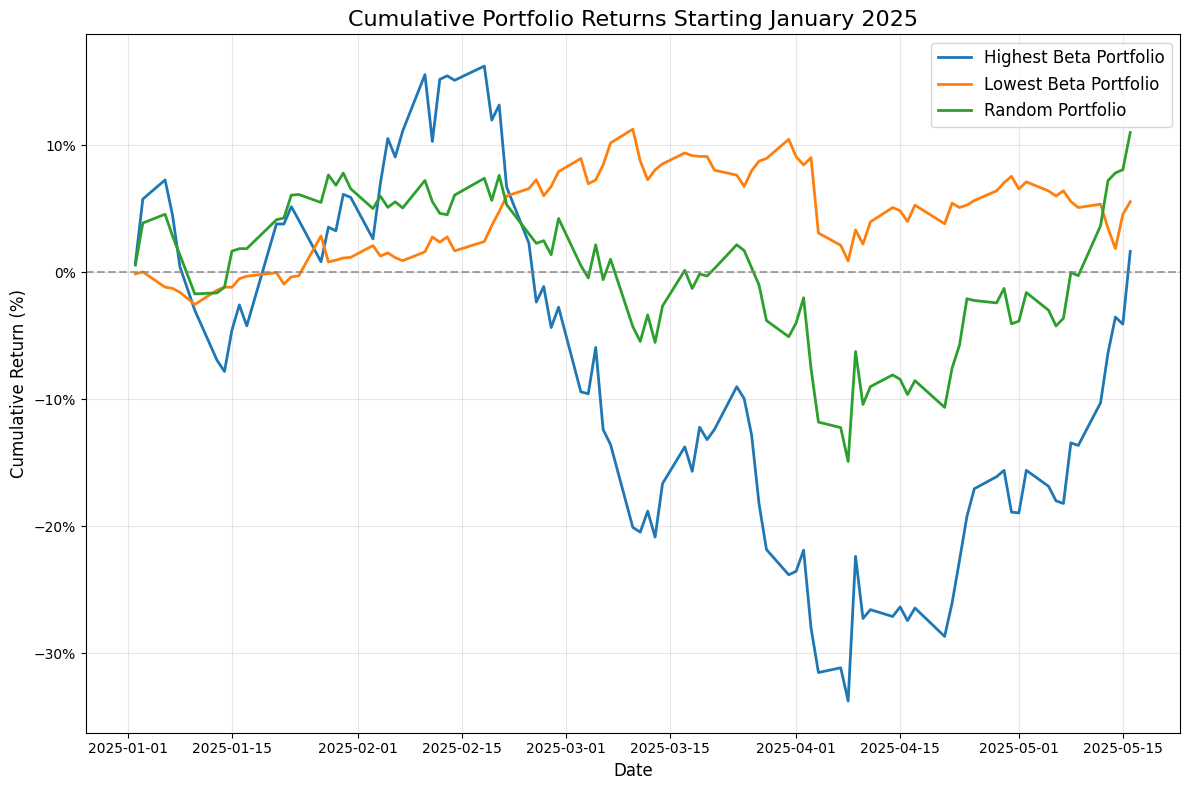

In [ ]:
# Calculate cumulative returns for each portfolio
highest_cumulative = (1 + highest_stock_portfolio_returns).cumprod() - 1
lowest_cumulative = (1 + lowest_stock_portfolio_returns).cumprod() - 1
random_cumulative = (1 + random_stock_portfolio_returns).cumprod() - 1

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(highest_cumulative.index, highest_cumulative, label='Highest Beta Portfolio', linewidth=2)
plt.plot(lowest_cumulative.index, lowest_cumulative, label='Lowest Beta Portfolio', linewidth=2)
plt.plot(random_cumulative.index, random_cumulative, label='Random Portfolio', linewidth=2)

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Add labels and title
plt.title('Cumulative Portfolio Returns Starting January 2025', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(fontsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.show()